<a href="https://colab.research.google.com/github/shoaibrayeen/Object-Recognition-in-Deep-Learning/blob/master/FaceMask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

from google.colab import drive
from pathlib import Path
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [28]:
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import os
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

import sys

from pathlib import Path
base = Path('/gdrive/My Drive/face-mask-dataset/')
sys.path.append(str(base))

In [18]:

train_dir = os.path.join(base, 'data')
val_dir = os.path.join(base, 'validation/test')
category_train = os.listdir(train_dir)
category_val = os.listdir(val_dir)
print(train_dir, val_dir, category_train, category_val)

/gdrive/My Drive/experiements/data /gdrive/My Drive/experiements/validation/test ['without_mask', 'with_mask'] ['without_mask', 'with_mask']


In [19]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 1
ncols = 8

# Index for iterating over images
pic_index = 0

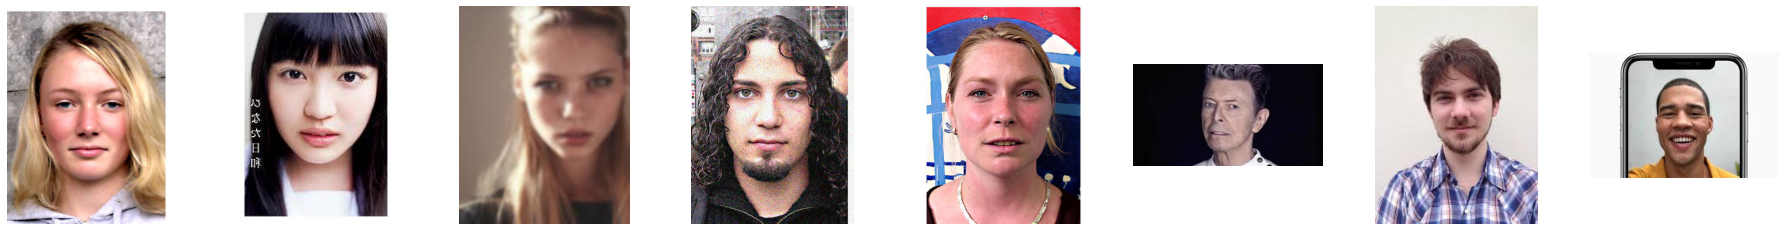

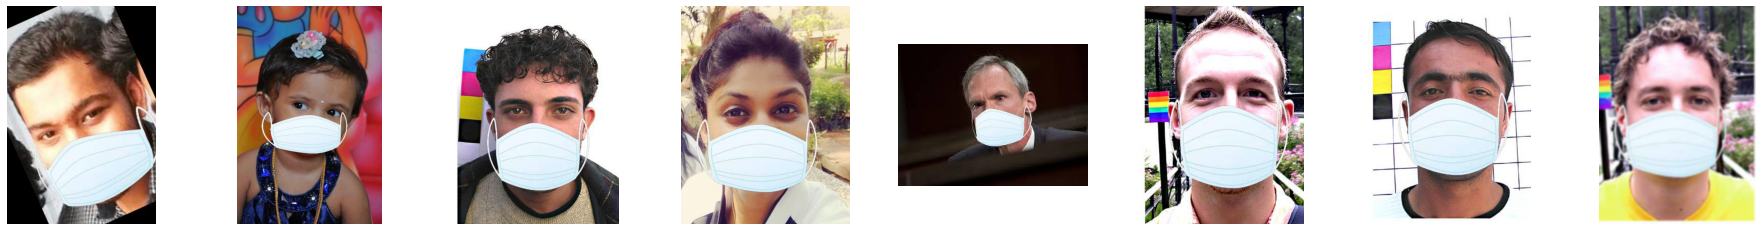

In [20]:
pic_index += 8

for it in category_train:
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 4, nrows * 4)
  train_cat_dir = os.path.join(train_dir, it)
  train_cat_fnames = os.listdir(train_cat_dir)
  next_pix = [os.path.join(train_cat_dir, fname) 
                  for fname in train_cat_fnames[pic_index-8:pic_index]]

  for i, img_path in enumerate(next_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

In [22]:
print("The number of images with facemask labelled - Training - 'yes':",len(os.listdir(train_dir + '/with_mask')))
print("The number of images with facemask labelled - Training - 'no':",len(os.listdir(train_dir + '/without_mask')))
print("The number of images with facemask labelled - Validation - 'yes':",len(os.listdir(val_dir + '/with_mask')))
print("The number of images with facemask labelled - Validation - 'no':",len(os.listdir(val_dir + '/without_mask')))

The number of images with facemask labelled - Training - 'yes': 690
The number of images with facemask labelled - Training - 'no': 686
The number of images with facemask labelled - Validation - 'yes': 219
The number of images with facemask labelled - Validation - 'no': 97


In [24]:
def data_summary(main_path):
    
    yes_path = main_path+'/with_mask'
    no_path = main_path+'/without_mask'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of positive examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of negative examples: {m_neg}") 
    
data_summary(train_dir)
data_summary(val_dir)

Number of examples: 1376
Percentage of positive examples: 50.145348837209305%, number of positive examples: 690
Percentage of negative examples: 49.854651162790695%, number of negative examples: 686
Number of examples: 316
Percentage of positive examples: 69.30379746835443%, number of positive examples: 219
Percentage of negative examples: 30.696202531645568%, number of negative examples: 97


In [25]:
train_files = sum([len(files) for i, j, files in os.walk(train_dir)])
val_files = sum([len(files) for i, j, files in os.walk(val_dir)])
print(train_files, val_files)

1376 316


In [26]:
n_classes = 5
epochs = 30
nb_train_samples = train_files
nb_validation_samples = val_files
num_epochs = epochs



img_width, img_height = 150, 150
train_data_dir = train_dir
validation_data_dir = val_dir
batch_size = 32

In [29]:
# Our input feature map is 150x150x3: 165x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(img_width, img_height, 3))

# First convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [30]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create a fully connected layer with ReLU activation and 128 hidden units
x = layers.Dense(128, activation='relu')(x)

# Create output layer with 5 nodes and softmax activation
output = layers.Dense(2, activation='softmax')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

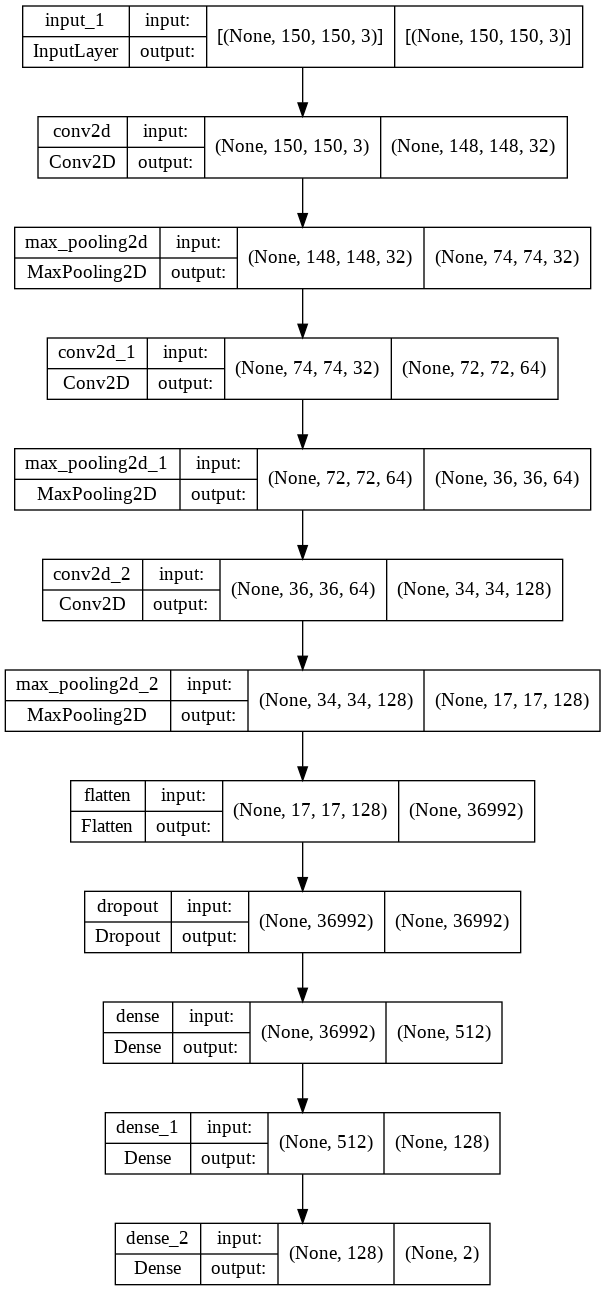

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [32]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856 

In [33]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [40]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')


FileNotFoundError: ignored

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

# history = model.fit_generator(train_generator,
#                     steps_per_epoch = nb_train_samples // batch_size,
#                     validation_data=validation_generator,
#                     validation_steps=nb_validation_samples // batch_size,
#                     epochs=num_epochs,
#                     verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 220 steps, validate for 56 steps
Epoch 1/30
220/220 [==============================] - 237s 1s/step - loss: 0.0922 - acc: 0.9682 - val_loss: 0.1251 - val_acc: 0.9546
Epoch 2/30
220/220 [==============================] - 247s 1s/step - loss: 0.1026 - acc: 0.9686 - val_loss: 0.1050 - val_acc: 0.9619
Epoch 3/30
220/220 [==============================] - 263s 1s/step - loss: 0.0731 - acc: 0.9786 - val_loss: 0.5988 - val_acc: 0.7550
Epoch 4/30
220/220 [==============================] - 231s 1s/step - loss: 0.0733 - acc: 0.9741 - val_loss: 0.1133 - val_acc: 0.9528
Epoch 5/30
220/220 [==============================] - 231s 1s/step - loss: 0.1414 - acc: 0.9541 - val_loss: 0.1225 - val_acc: 0.9564
Epoch 6/30
220/220 [==============================] - 233s 1s/step - loss: 0.1031 - acc: 0.9645 - val_loss: 0.1323 - val_acc: 0.9583
Epoch 7/30
220/220 [==============================] - 238s 1s/step - loss: 0.0967 - acc: 0.9695 - val_loss: 0

In [ ]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(150,150))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()